# Lab 01 — From Machine Learning to AI?

## Section 0 — Can Machines Think?

> **“Can machines think?”**  
> In 1950, Alan Turing reframed this question as a simple game: put a human judge in a room with two hidden interlocutors—one human, one machine—and see if the judge can tell them apart. If not, the machine “passes” the test and is deemed intelligent.

That bold idea kicked off **artificial intelligence**. Since then, innovations in theory, algorithms, and hardware have spawned entire fields:

- **Computer Vision** ▸ Can machines “see” the world like we do?  
- **Natural Language Processing** ▸ Can machines understand and generate human language?  
- **Robotics** ▸ Can machines move and interact in physical environments?  
- **Forecasting** ▸ Can machines predict tomorrow’s outcomes as well as—or better than—experts?

…and many more areas exploring how machines can perceive, reason, and act.

Today’s breakthroughs—like convolutional nets for images, transformers for language, and diffusion models for creativity—bring us closer than ever to “thinking” machines. Sometimes they even outperform humans on specific tasks. But **how did we get here?**

---

In **Lab 01**, we’ll retrace the **153-year journey** from  
- **Linear Regression** (Legendre, 1805)  
to  
- **The Perceptron** (Rosenblatt, 1958)  

Over **15 hours** of hands-on exercises, you will:

- Derive and implement **least-squares regression** from scratch  
- Compare the closed-form solution to **stochastic gradient descent**  
- Build and train a **single-layer perceptron**  
- Upgrade to a **two-layer MLP** using PyTorch  
- Measure and compare **loss curves**, **accuracy**, **parameter counts**, and **FLOPs**

By the end, you’ll see exactly how simple linear models evolved into modern neural networks—and gain the skills to train them yourself.


In [ ]:
# Make sure you use efficientai conda kernel and it contains the required packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Section 1 — Rethinking Linear Regression

> **“When I say fundamental, I do not mean easy.”**  
> — Richard Feynman

Linear regression may be the simplest predictive model, yet it hides the core ideas behind every modern ML algorithm:

- **Weights & Bias** ▸ How do we adjust model parameters to fit data?  
- **Loss Function (MSE)** ▸ How do we quantify “goodness of fit”?  
- **Gradient Descent** ▸ How do we iteratively improve our model when no closed-form solution exists?

In this section you will:

1. **Derive** the closed-form least-squares solution.  
2. **Implement** linear regression from scratch in NumPy.  
3. **Compare** analytic solutions to stochastic gradient descent.  

By the end, you’ll see how these building blocks scale up to deep neural networks—and why mastering them is essential for efficient AI.  

**Task Description: Predicting Exam Performance by Eye**

You are an educational researcher looking for a simple rule to estimate a student’s exam score based on how many hours they studied. You have data from 15 students:

| Hours Studied | Exam Score (%) |
|---------------|----------------|
| 1             | …              |
| 2             | …              |
| …             | …              |
| 10            | …              |

Rather than immediately relying on a mathematical formula, your first job is to **use your intuition** to find a relationship of the form  
$$
\text{predicted score} = w \times (\text{hours}) + b
$$  
that seems to roughly pass through the cloud of points.  

- **Why?** By manually adjusting $w$ (the “points per hour” rate) and $b$ (the baseline score) you’ll develop a feel for how slope and intercept control the model’s predictions.  
- **How?** Run the provided code cell, tweak the values of `w` and `b`, and observe how your line moves relative to the data.  
- **Goal:** Find values of $w$ and $b$ that you believe would give reasonably accurate score predictions—without yet using any automated fitting method.  

This exercise builds your intuition for how linear regression parameters shape the fit before we dive into the formal derivations and algorithms.  


   hours_studied  exam_score
0       1.000000   63.320262
1       1.642857   59.393643
2       2.285714   65.179404
3       2.928571   74.383037
4       3.571429   75.409219


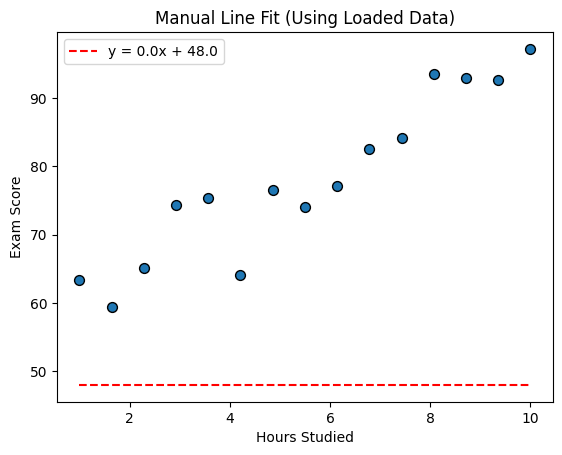

In [ ]:
# 1) Load the data
df_loaded = pd.read_csv("hours_vs_score.csv")
print(df_loaded.head())

# 2) Manually choose your line parameters (edit these!)
w = 0.0    # slope
b = 48.0   # intercept

# 3) Plot data and your line using the loaded DataFrame
plt.scatter(df_loaded["hours_studied"], df_loaded["exam_score"], s=50, edgecolor='k')
x = np.linspace(df_loaded["hours_studied"].min(), df_loaded["hours_studied"].max(), 100)
plt.plot(x, w * x + b, 'r--', label=f"y = {w:.1f}x + {b:.1f}")
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.title("Manual Line Fit (Using Loaded Data)")
plt.legend()
plt.show()


### From “By Eye” to “Best Fit”

Now that you’ve placed a line by eye, we need a **precise criterion** for what makes one line better than another.

#### 1. **Error for a single student**  
   For student *i* with hours $x_i$ and actual score $y_i$, if our prediction is  
   $$\hat y_i = w\,x_i + b,$$  
   then the **prediction error** is  
   $$e_i = y_i - \hat y_i.$$

#### 2. **Aggregating errors**  
   We want one number that summarizes how well the line fits **all** *n* students. Common choices include:  
   - **Mean Absolute Error (MAE):**  
     $$\frac{1}{n}\sum_{i=1}^n \bigl|e_i\bigr|$$  
   - **Mean Squared Error (MSE):**  
     $$\frac{1}{n}\sum_{i=1}^n e_i^2$$



### Comparing MSE vs. MAE

Below is a plot of the two most common regression losses as a function of the prediction error \(e\):

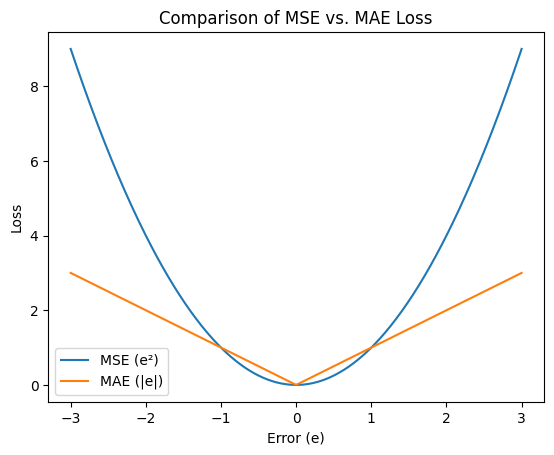

In [8]:
errors = np.linspace(-3, 3, 400)

# Compute MAE and MSE
mae = np.abs(errors)
mse = errors**2

# Plot both losses
plt.plot(errors, mse, label="MSE (e\u00b2)")
plt.plot(errors, mae, label="MAE (|e|)")
plt.xlabel("Error (e)")
plt.ylabel("Loss")
plt.title("Comparison of MSE vs. MAE Loss")
plt.legend()
plt.show()

| Loss        | Formula      | Shape          | Sensitivity to outliers | Gradient behavior     |
|-------------|--------------|----------------|-------------------------|-----------------------|
| **MSE**     | \(e^2\)      | Quadratic      | High (large errors get squared) | Smooth and continuous; large gradients for big errors |
| **MAE**     | \(\lvert e\rvert\) | Linear        | Moderate (errors weighted equally) | Piecewise constant gradient; nondifferentiable at \(e=0\) |

(i). **Quadratic vs. Linear**  
   - MSE grows as the *square* of the error, so a single large mistake can dominate the loss.  
   - MAE grows in direct proportion to the error, so all mistakes contribute evenly.

(2). **Outlier impact**  
   - With MSE, outliers (very large residuals) heavily influence the fitted model, since squaring magnifies their effect.  
   - MAE is more robust: all residuals count the same per unit error.

(3). **Optimization considerations**  
   - MSE’s smooth derivative (\(2e\)) makes gradient-based optimization straightforward and stable.  
   - MAE’s derivative is \(\pm1\) (undefined exactly at 0), which can slow convergence or require specialized solvers.

**When to use which?**

- Use **MSE** if you want your model to focus on reducing large errors and benefit from smooth gradients.  
- Use **MAE** if you need robustness against outliers or if absolute deviations are more meaningful for your application.


#### 3. **Defining “Best”**  
   The “best” line $(w^*, b^*)$ is the one that **minimizes** our chosen aggregate error. For MSE:  
   $$
   (w^*,b^*) = \arg\min_{w,b}\;\frac{1}{n}\sum_{i=1}^n\bigl(y_i - (w\,x_i + b)\bigr)^2.
   $$

#### 4 — A Solution?

We have data $(x_i, y_i)$ for $i = 1, \dots, n$. Our goal is to find

$$
(w^*, b^*) = \arg\min_{w,b} \; \frac{1}{n} \sum_{i=1}^n \bigl(y_i - (w\,x_i + b)\bigr)^2.
$$

Because this loss is convex in $w$ and $b$, the minimum occurs where its first derivatives vanish.

Setting the partial derivatives to zero gives the normal equations:

$$
\begin{aligned}
\frac{\partial}{\partial w}:&\quad -\frac{2}{n} \sum_{i=1}^n x_i \bigl(y_i - (w\,x_i + b)\bigr) = 0,\\
\frac{\partial}{\partial b}:&\quad -\frac{2}{n} \sum_{i=1}^n \bigl(y_i - (w\,x_i + b)\bigr) = 0.
\end{aligned}
$$

Solving these yields the closed-form least-squares solution:

$$
\begin{aligned}
w^* &= \frac{\sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^n (x_i - \bar{x})^2},\\
b^* &= \bar{y} - w^*\,\bar{x},
\end{aligned}
$$

where

$$
\bar{x} = \frac{1}{n} \sum_{i=1}^n x_i,
\quad
\bar{y} = \frac{1}{n} \sum_{i=1}^n y_i.
$$

Now it seems like that we have a best solution candidate, can you calculate the closed form least square solution using code?


Least-squares: y = 0.00x + 0.00


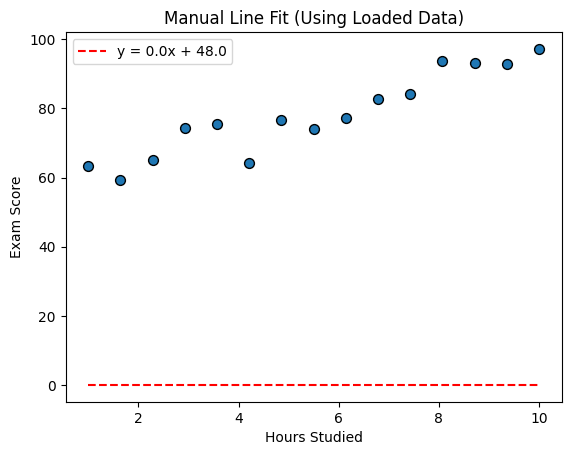

In [15]:
# Load the data
df = pd.read_csv("hours_vs_score.csv")

# 1) Please implement the least-squares solution here
x_mean, y_mean = 0,0
w_ls = 0
b_ls = 0

print(f"Least-squares: y = {w_ls:.2f}x + {b_ls:.2f}")

# The least-squares solution should be pretty good if you implemented it correctly.
plt.scatter(df_loaded["hours_studied"], df_loaded["exam_score"], s=50, edgecolor='k')
x = np.linspace(df_loaded["hours_studied"].min(), df_loaded["hours_studied"].max(), 100)
plt.plot(x, w_ls * x + b_ls, 'r--', label=f"y = {w:.1f}x + {b:.1f}")
plt.xlabel("Hours Studied")
plt.ylabel("Exam Score")
plt.title("Manual Line Fit (Using Loaded Data)")
plt.legend()
plt.show()

### Open-Ended Questions: Beyond the Closed-Form Fit

1. **Units Matter**  
   - If you measured study time in **minutes** instead of hours, what are the new values of $w^*$ and $b^*$?  
   - What does this tell you about the relationship between your model’s parameters and the data’s units?

2. **Polynomial Extensions**  
   - Real-world relationships aren’t always linear. Derive and solve the closed-form normal equations for a **quadratic** model  
     $
       \hat y = a\,x^2 + b\,x + c
     $  
     on the same data.  
   - How does the predictive performance (e.g. on a held-out validation split) compare between the straight-line and quadratic fits?

3. **Sensitivity to Data Changes**  
   - Remove one or two data points (for example, the smallest or largest study times), recompute $(w^*, b^*)$, and observe how the fitted line shifts.  
   - Which points have the greatest influence on your model’s predictions, and what does that imply for the reliability of a single linear rule?  


## Section 2: From Linearity To Non-Linearity

## Section 3: A Neural Network